In [ ]:
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2021-09-30 17:24:54--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 13.226.115.49, 13.226.115.117, 13.226.115.3, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|13.226.115.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  18.4MB/s    in 23s     

2021-09-30 17:25:18 (14.5 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [ ]:
!mv cell_images.zip '/content/drive/MyDrive/Malaria Cell Detection'

In [ ]:
!unzip '/content/drive/MyDrive/Malaria Cell Detection/cell_images.zip' -d '/content/drive/MyDrive/Malaria Cell Detection'

Streaming output truncated to the last 5000 lines.
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: /content/drive/MyDrive/Malaria Cell Detection/c

### Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import seaborn as sns
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow_hub as hub
from tensorflow.keras import layers

### Paths of directories

In [3]:
parasitized_dir='drive/MyDrive/Malaria_Cell_Detection/cell_images/Parasitized/'
uninfected_dir="drive/MyDrive/Malaria_Cell_Detection/cell_images/Uninfected/"
w_dir="drive/MyDrive/Malaria_Cell_Detection/cell_images/"
train_dir="drive/MyDrive/Malaria_Cell_Detection/cell_images/train/"
test_dir="drive/MyDrive/Malaria_Cell_Detection/cell_images/test/"
valid_dir="drive/MyDrive/Malaria_Cell_Detection/cell_images/validation/"

### Walk through malaria_cell directory and list number of files

In [ ]:
for dirpath, dirnames, filenames in os.walk(w_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/'.
There are 0 directories and 11069 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/Uninfected'.
There are 0 directories and 13780 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/Parasitized'.
There are 2 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/test'.
There are 0 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/test/Uninfected'.
There are 0 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/test/Parasitized'.
There are 2 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/train'.
There are 0 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/train/Parasitized'.
There are 0 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/train/Uninfected'.
There are 2 directories and 0 images in 'drive/MyDrive/Malari

### Function to show a random image of the targetted class

In [ ]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  plt.figure()
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

### View a random image from directory

Image shape: (124, 148, 3)
Image shape: (151, 148, 3)


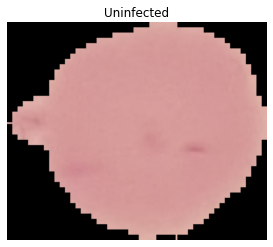

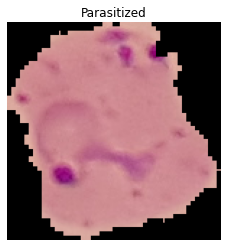

In [ ]:
img = view_random_image(target_dir=train_dir,
                        target_class="Uninfected")
img = view_random_image(target_dir=train_dir,
                        target_class="Parasitized")

### Make a dataframe consisting of image paths and its corresponding label

In [ ]:
def data_prep(parasitized,uninfected):
    parasitized= [parasitized_dir +  parasitize for parasitize in parasitized]
    uninfected= [uninfected_dir +  uninfect for uninfect in uninfected]
    labels = len(parasitized)*['Parasitized'] + len(uninfected)*['Uninfected']
    data = parasitized + uninfected
    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

df = data_prep(os.listdir(parasitized_dir), os.listdir(uninfected_dir))
df.head()

,Image_Path,Labels
0,drive/MyDrive/Malaria_Cell_Detection/cell_imag...,Parasitized
1,drive/MyDrive/Malaria_Cell_Detection/cell_imag...,Parasitized
2,drive/MyDrive/Malaria_Cell_Detection/cell_imag...,Parasitized
3,drive/MyDrive/Malaria_Cell_Detection/cell_imag...,Parasitized
4,drive/MyDrive/Malaria_Cell_Detection/cell_imag...,Parasitized


### Split the data into train,test and validation set

In [ ]:
image_paths=df['Image_Path']
y=df['Labels']
X_train,X_test,y_train,y_test=train_test_split(image_paths,y,test_size=0.2,random_state=42)
X_train,X_validation,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.2,random_state=42)
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values
X_validation=X_validation.values
y_validation=y_validation.values

### Move the data to its targetted folder

In [ ]:
def move_data_to_dir():
  for i in range(len(X_train)):
    from_dir=X_train[i]
    to_dir=train_dir+y_train[i]
    !mv $from_dir $to_dir

    if i<len(X_test):
      from_dir=X_test[i]
      to_dir=test_dir+y_test[i]
      !mv $from_dir $to_dir

    if i<len(X_validation):
      from_dir=X_validation[i]
      to_dir=valid_dir+y_validation[i]
      !mv $from_dir $to_dir
      
move_data_to_dir()

### After moving the data to the train, test and validation folder of drive

In [ ]:
for dirpath, dirnames, filenames in os.walk(w_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/'.
There are 0 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/Uninfected'.
There are 0 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/Parasitized'.
There are 2 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/test'.
There are 0 directories and 2206 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/test/Uninfected'.
There are 0 directories and 2786 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/test/Parasitized'.
There are 2 directories and 0 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/train'.
There are 0 directories and 8807 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/train/Parasitized'.
There are 0 directories and 7085 images in 'drive/MyDrive/Malaria_Cell_Detection/cell_images/train/Uninfected'.
There are 2 directories and 0 images in 'drive/MyDrive/Ma

In [4]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

Found 15891 images belonging to 2 classes.
Found 3965 images belonging to 2 classes.


In [5]:
# Set the seed
tf.random.set_seed(42)
test_datagen = ImageDataGenerator(rescale=1./255)
test_data=test_datagen.flow_from_directory(test_dir,
                                           batch_size=32,
                                           target_size=(224, 224), # convert all images to be 224 x 224
                                           class_mode="binary", # type of problem we're working on
                                           shuffle=False,
                                           seed=42)

Found 4992 images belonging to 2 classes.


### Augmented data

In [6]:
# Set random seed
tf.random.set_seed(42)
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='binary',
                                                                  seed=42)

Found 15891 images belonging to 2 classes.


### Function for evaluation metrics

In [7]:
def evaluate_mat(model,test_set):
  '''
    model : pass the model
    test_set : pass the test data
  '''
  metrics=model.evaluate(test_set)
  metrics_dic=dict(zip(['loss','true_positives','true_negatives','false_positives',
                        'false_negatives','accuracy','precision','recall'],
                       metrics))
  metrics_dic['f1_score']=(2*metrics_dic['precision']*metrics_dic['recall'])/(metrics_dic['precision']+metrics_dic['recall'])
  accuracy=metrics_dic['accuracy']
  precision=metrics_dic['precision']
  recall=metrics_dic['recall']
  f1=metrics_dic['f1_score']
  metric_list=[round(accuracy*100,2),round(precision*100,2),round(recall*100,2),round(f1*100,2)]
  cm = [[metrics_dic['true_positives'],metrics_dic['false_positives']],
         [metrics_dic['false_negatives'],metrics_dic['true_negatives']]]
  df_cm = pd.DataFrame(cm,
                     index=list(train_data.class_indices.keys()),
                     columns=list(train_data.class_indices.keys()))
  return metric_list,df_cm,metrics_dic

### Function for showing performance metrics

In [8]:
def show_performance_metrics(perf_metrics,model_name):
  '''
    perf_metrics (dict): dictionary of performance metrics
    model_name (str): model name
  '''
  app_model={}
  app_model[model_name]=perf_metrics
  df=pd.DataFrame(app_model,index=['Accuracy','Precision','Recall','F1-Score'])
  df.to_csv('drive/MyDrive/malaria_cell_detection_models/'+model_name+'_perf_mat.csv')
  print(df)

### Function for plotting the validation and training data separately

In [9]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(15,5))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### **Experiment-1: `Deep Neural Network`**

In [ ]:
# Set random seed
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=['TruePositives','TrueNegatives','FalsePositives','FalseNegatives','accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/20
497/497 [==============================] - 127s 253ms/step - loss: 0.7146 - true_positives: 3874.0000 - true_negatives: 6077.0000 - false_positives: 2729.0000 - false_negatives: 3211.0000 - accuracy: 0.6262 - precision: 0.5867 - recall: 0.5468 - val_loss: 0.6363 - val_true_positives: 1489.0000 - val_true_negatives: 1009.0000 - val_false_positives: 1178.0000 - val_false_negatives: 289.0000 - val_accuracy: 0.6300 - val_precision: 0.5583 - val_recall: 0.8375
Epoch 2/20
497/497 [==============================] - 76s 153ms/step - loss: 0.6207 - true_positives: 4079.0000 - true_negatives: 6490.0000 - false_positives: 2316.0000 - false_negatives: 3006.0000 - accuracy: 0.6651 - precision: 0.6378 - recall: 0.5757 - val_loss: 0.5979 - val_true_positives: 1373.0000 - val_true_negatives: 1326.0000 - val_false_positives: 861.0000 - val_false_negatives: 405.0000 - val_accuracy: 0.6807 - val_precision: 0.6146 - val_recall: 0.7722
Epoch 3/20
497/497 [==============================] - 76s 15

#### Model's summary

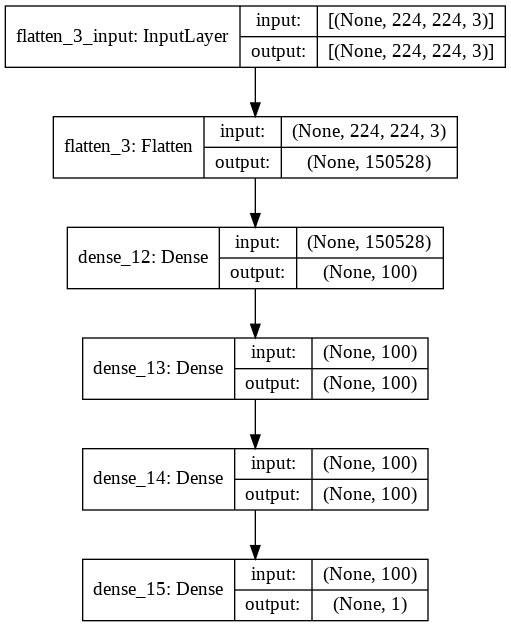

In [ ]:
# See the inputs and outputs of each layer
plot_model(model_1, show_shapes=True)

#### Evaluate the model on test-set

In [ ]:
perf_mat,conf_mat,overall_mat=evaluate_mat(model_1,test_data)

156/156 [==============================] - 19s 115ms/step - loss: 0.5754 - true_positives: 1344.0000 - true_negatives: 2223.0000 - false_positives: 563.0000 - false_negatives: 862.0000 - accuracy: 0.7145 - precision: 0.7048 - recall: 0.6092


##### Confusion matrix

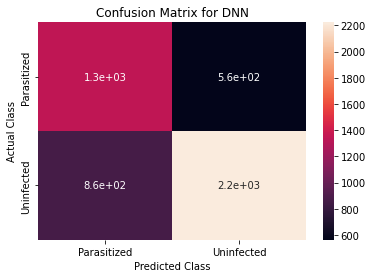

In [ ]:
sns.heatmap(conf_mat, annot=True)
plt.title('Confusion Matrix for DNN')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class');

##### Performance metrics

In [ ]:
show_performance_metrics(perf_mat,'DNN')

             DNN
Accuracy   71.45
Precision  70.48
Recall     60.92
F1-Score   65.35


##### Visualize the loss curves

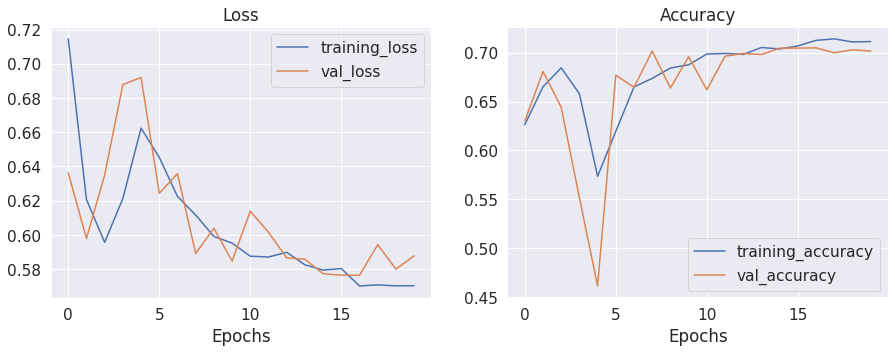

In [ ]:
plot_loss_curves(history_1)

#### Save the DNN model

In [ ]:
model_1.save('drive/MyDrive/malaria_cell_detection_models/dnn_model')

INFO:tensorflow:Assets written to: drive/MyDrive/malaria_cell_detection_models/dnn_model/assets


### **Experiment-2: `Convolutional Neural Network`**

In [ ]:
# Set random seed
tf.random.set_seed(42)
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=['TruePositives','TrueNegatives','FalsePositives','FalseNegatives','accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# Fit the model
history_2 = model_2.fit(train_data_augmented,
                        epochs=15,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/15
497/497 [==============================] - 243s 486ms/step - loss: 0.6330 - true_positives: 3435.0000 - true_negatives: 6654.0000 - false_positives: 2152.0000 - false_negatives: 3650.0000 - accuracy: 0.6349 - precision_3: 0.6148 - recall_3: 0.4848 - val_loss: 0.6778 - val_true_positives: 324.0000 - val_true_negatives: 1939.0000 - val_false_positives: 248.0000 - val_false_negatives: 1454.0000 - val_accuracy: 0.5707 - val_precision_3: 0.5664 - val_recall_3: 0.1822
Epoch 2/15
497/497 [==============================] - 239s 482ms/step - loss: 0.6782 - true_positives: 1749.0000 - true_negatives: 7333.0000 - false_positives: 1473.0000 - false_negatives: 5336.0000 - accuracy: 0.5715 - precision_3: 0.5428 - recall_3: 0.2469 - val_loss: 0.6414 - val_true_positives: 1243.0000 - val_true_negatives: 1284.0000 - val_false_positives: 903.0000 - val_false_negatives: 535.0000 - val_accuracy: 0.6373 - val_precision_3: 0.5792 - val_recall_3: 0.6991
Epoch 3/15
497/497 [========================

#### Model's summary

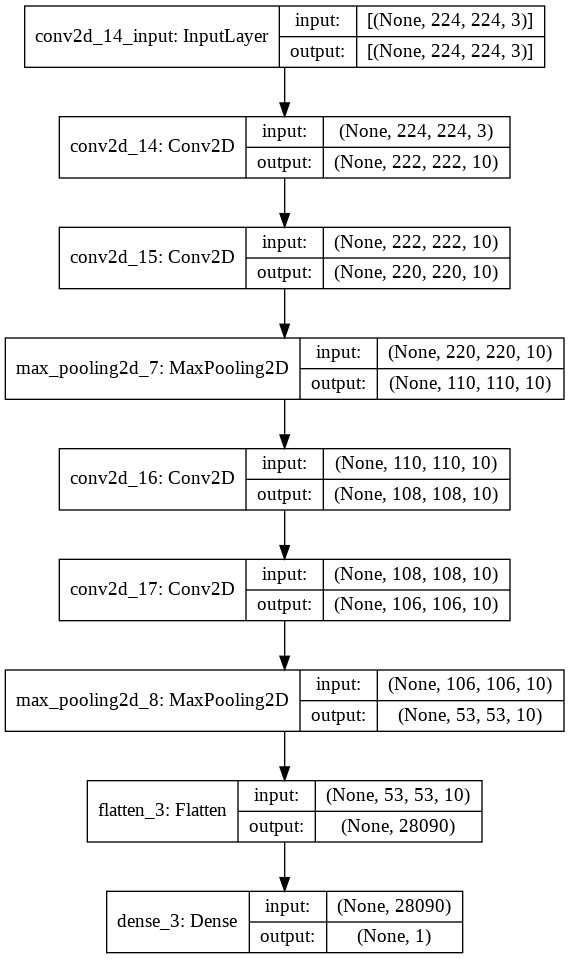

In [ ]:
# See the inputs and outputs of each layer
plot_model(model_2, show_shapes=True)

#### Evaluate the model on test-set

In [ ]:
perf_mat,conf_mat,overall_mat=evaluate_mat(model_2,test_data)

156/156 [==============================] - 19s 120ms/step - loss: 0.1891 - true_positives: 2129.0000 - true_negatives: 2567.0000 - false_positives: 219.0000 - false_negatives: 77.0000 - accuracy: 0.9407 - precision_3: 0.9067 - recall_3: 0.9651


##### Confusion matrix

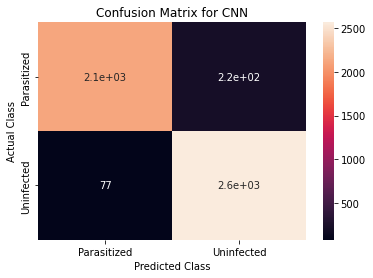

In [ ]:
sns.heatmap(conf_mat, annot=True)
plt.title('Confusion Matrix for CNN')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class');

##### Performance metrics

In [ ]:
show_performance_metrics(perf_mat,'cnn')

             cnn
Accuracy   94.07
Precision  90.67
Recall     96.51
F1-Score   93.50


##### Visualize the loss curves

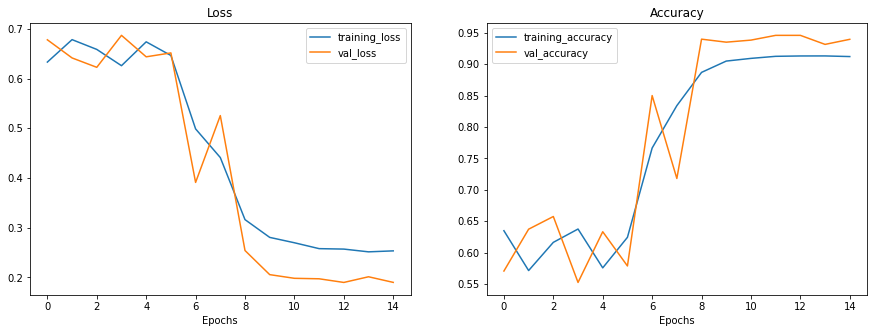

In [ ]:
plot_loss_curves(history_2)

#### Save the CNN model

In [ ]:
model_2.save('drive/MyDrive/malaria_cell_detection_models/cnn_model')

INFO:tensorflow:Assets written to: drive/MyDrive/malaria_cell_detection_models/cnn_model/assets


In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

### **Experiment-3: `ResNet50`**

In [11]:
def create_model(model_url):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224,224,3)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [19]:
# Create model
resnet_model = create_model(resnet_url)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['TruePositives','TrueNegatives','FalsePositives','FalseNegatives','accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
# Fit the model
resnet_history = resnet_model.fit(train_data_augmented,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/10
497/497 [==============================] - 268s 528ms/step - loss: 0.3131 - true_positives: 6097.0000 - true_negatives: 7648.0000 - false_positives: 1158.0000 - false_negatives: 988.0000 - accuracy: 0.8650 - precision_5: 0.8404 - recall_5: 0.8606 - val_loss: 0.2412 - val_true_positives: 1660.0000 - val_true_negatives: 1908.0000 - val_false_positives: 279.0000 - val_false_negatives: 118.0000 - val_accuracy: 0.8999 - val_precision_5: 0.8561 - val_recall_5: 0.9336
Epoch 2/10
497/497 [==============================] - 267s 538ms/step - loss: 0.2385 - true_positives: 6465.0000 - true_negatives: 7906.0000 - false_positives: 900.0000 - false_negatives: 620.0000 - accuracy: 0.9043 - precision_5: 0.8778 - recall_5: 0.9125 - val_loss: 0.2070 - val_true_positives: 1635.0000 - val_true_negatives: 2000.0000 - val_false_positives: 187.0000 - val_false_negatives: 143.0000 - val_accuracy: 0.9168 - val_precision_5: 0.8974 - val_recall_5: 0.9196
Epoch 3/10
497/497 [===========================

#### Model's summary

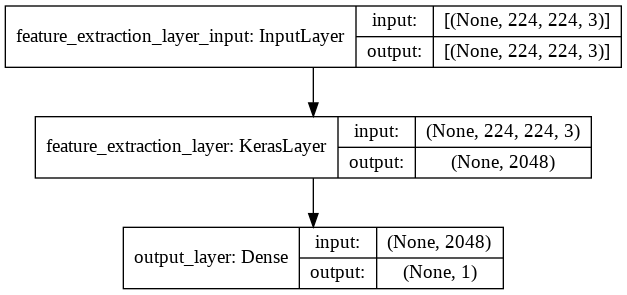

In [20]:
# See the inputs and outputs of each layer
plot_model(resnet_model, show_shapes=True)

#### Evaluate the model on test-set

In [23]:
perf_mat,conf_mat,overall_mat=evaluate_mat(resnet_model,test_data)

156/156 [==============================] - 1101s 7s/step - loss: 0.1906 - true_positives: 2138.0000 - true_negatives: 2479.0000 - false_positives: 307.0000 - false_negatives: 68.0000 - accuracy: 0.9249 - precision_5: 0.8744 - recall_5: 0.9692


##### Confusion matrix

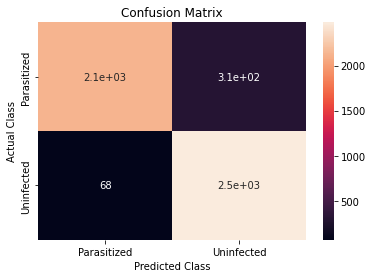

In [24]:
sns.heatmap(conf_mat, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class');

##### Performance metrics

In [25]:
show_performance_metrics(perf_mat,'Frozen CNN')

           Frozen CNN
Accuracy        92.49
Precision       87.44
Recall          96.92
F1-Score        91.94


##### Visualize the loss curves

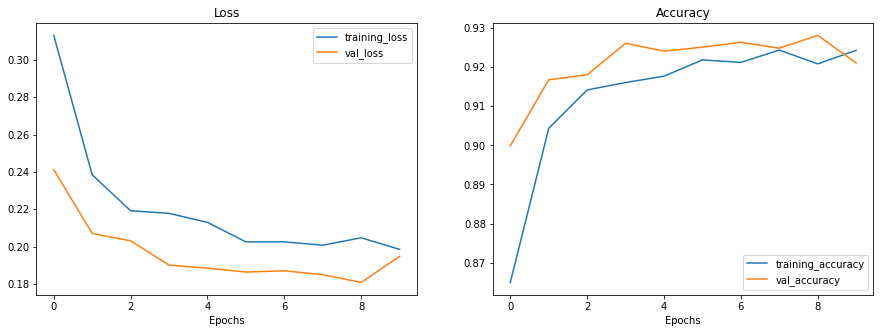

In [26]:
plot_loss_curves(resnet_history)

#### Save the CNN model

In [27]:
resnet_model.save('drive/MyDrive/malaria_cell_detection_models/resnet_model')

INFO:tensorflow:Assets written to: drive/MyDrive/malaria_cell_detection_models/resnet_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/malaria_cell_detection_models/resnet_model/assets
